# Importing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import multiprocessing
import copy
import pickle
import warnings
from datetime import datetime
from time import time
from matplotlib import font_manager as fm, rc
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from numpy import array, nan, random as rnd, where as which
import pandas as pd
from pandas import DataFrame as dataframe, Series as series, isna, isnull, read_csv
from pandas.tseries.offsets import DateOffset
from scipy.special import boxcox1p
from scipy.stats import skew

# from sklearn import datasets
!pip install yfinance
import yfinance
from sklearn import preprocessing as prep
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split as tts, GridSearchCV as GridTuner, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.pipeline import make_pipeline

from sklearn import linear_model as lm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn import neighbors as knn
from sklearn import ensemble

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import metrics as tf_metrics
from tensorflow.keras import callbacks as tf_callbacks
from tqdm.keras import TqdmCallback
!pip install scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow_addons as tfa
import keras_tuner as kt
from keras_tuner import HyperModel

# display setting
warnings.filterwarnings(action='ignore')

# plot setting
myColors = sns.hls_palette(10, s=0.4)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=09381aff137e4689a189c35eba506bf93936a434b55fc9e6c9524aae52f17c33
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8375 sha256=423381294a87eb204420c51fbe231478493e5eef6ff85e8b546fd82381e09b1f
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking


2021-09-24 01:35:12.845804: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-24 01:35:12.845922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Utility Functions

In [2]:
class MyLabelEncoder:
    def __init__(self, preset={}):
        # dic_cat format -> {"col_name": {"value": replace}}
        self.dic_cat = preset
    def fit_transform(self, data_x, col_names):
        tmp_x = copy.deepcopy(data_x)
        for i in col_names:
            # type check
            if not ((tmp_x[i].dtype.name == "object") or (tmp_x[i].dtype.name == "category")):
                print(F"WARNING : {i} is not object or category")
            # if key is not in dic, update dic
            if i not in self.dic_cat.keys():
                tmp_dic = dict.fromkeys(sorted(set(tmp_x[i]).difference([nan])))
                label_cnt = 0
                for j in tmp_dic.keys():
                    tmp_dic[j] = label_cnt
                    label_cnt += 1
                self.dic_cat[i] = tmp_dic
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x
    def transform(self, data_x, col_names):
        tmp_x = copy.deepcopy(data_x)
        for i in col_names:
            if not ((tmp_x[i].dtype.name == "object") or (tmp_x[i].dtype.name == "category")):
                print(F"WARNING : {i} is not object or category")
            # transform value which is not in dic to nan
            tmp_x[i] = tmp_x[i].astype("object")
            conv = tmp_x[i].replace(self.dic_cat[i])
            for conv_idx, j in enumerate(conv):
                if j not in self.dic_cat[i].values():
                    conv[conv_idx] = nan
            # final return
            tmp_x[i] = conv.astype("float")
        return tmp_x

    def clear(self, dic_cat={}):
        self.dic_cat = dic_cat
class MyOneHotEncoder:
    def __init__(self, label_preset={}):
        self.dic_cat = {}
        self.label_preset = label_preset
    def fit_transform(self, data_x, col_names):
        tmp_x = dataframe()
        for i in data_x:
            if i not in col_names:
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                self.dic_cat[i] = OneHotEncoder(sparse=False, handle_unknown="ignore")
                conv = self.dic_cat[i].fit_transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j:
                                col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def transform(self, data_x, col_names):
        tmp_x = dataframe()
        for i in data_x:
            if not i in col_names:
                tmp_x = pd.concat([tmp_x, dataframe(data_x[i])], axis=1)
            else:
                if not ((data_x[i].dtype.name == "object") or (data_x[i].dtype.name == "category")):
                    print(F"WARNING : {i} is not object or category")
                conv = self.dic_cat[i].transform(dataframe(data_x[i])).astype("int")
                col_list = []
                for j in self.dic_cat[i].categories_[0]:
                    if i in self.label_preset.keys():
                        for k, v in self.label_preset[i].items():
                            if v == j: col_list.append(str(i) + "_" + str(k))
                    else:
                        col_list.append(str(i) + "_" + str(j))
                conv = dataframe(conv, columns=col_list)
                tmp_x = pd.concat([tmp_x, conv], axis=1)
        return tmp_x
    def clear(self, dic_cat={}, label_preset={}):
        self.dic_cat = dic_cat
        self.label_preset = label_preset
class MyKNNImputer:
    def __init__(self, k=5):
        self.imputer = KNNImputer(n_neighbors=k)
        self.cat_dic = {}
        self.naidx_dix = {}
    def fit_transform(self, x, y, cat_vars=None):
        for i in cat_vars:
            self.cat_dic[i] = diff(list(sorted(set(x[i]))), [nan])
            self.naidx_dix[i] = list(which(array(x[i].isna()))[0])
        x_imp = dataframe(self.imputer.fit_transform(x, y), columns=x.columns)

        # if imputed categorical value are not in the range, adjust the value
        for i in cat_vars:
            x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
            for j in self.naidx_dix[i]:
                if x_imp[i][j] not in self.cat_dic[i]:
                    if x_imp[i][j] < self.cat_dic[i][0]:
                        x_imp[i][self.naidx_dix[i]] = self.cat_dic[i][0]
                    elif x_imp[i][j] > self.cat_dic[i][0]:
                        x_imp[i][self.naidx_dix[i]] = self.cat_dic[i][len(self.cat_dic[i]) - 1]
        return x_imp
    def transform(self, x):
        for i in self.cat_dic.keys():
            self.naidx_dix[i] = list(which(array(x[i].isna()))[0])
        x_imp = dataframe(self.imputer.transform(x), columns=x.columns)

        # if imputed categorical value are not in the range, adjust the value
        for i in self.cat_dic.keys():
            x_imp[i] = x_imp[i].apply(lambda x: int(round(x, 0)))
            for j in self.naidx_dix[i]:
                if x_imp[i][j] not in self.cat_dic[i]:
                    if x_imp[i][j] < self.cat_dic[i][0]:
                        x_imp[i][self.naidx_dix[i]] = self.cat_dic[i][0]
                    elif x_imp[i][j] > self.cat_dic[i][0]:
                        x_imp[i][self.naidx_dix[i]] = self.cat_dic[i][len(self.cat_dic[i]) - 1]
        return x_imp
    def clear(self, cat_dic={}, naidx_dix={}):
        self.cat_dic = cat_dic
        self.naidx_dix = naidx_dix
def easyIO(x=None, path=None, op="r"):
    tmp = None
    if op == "r":
        with open(path, "rb") as f:
            tmp = pickle.load(f)
        return tmp
    elif op == "w":
        tmp = {}
        print(x)
        if type(x) is dict:
            for k in x.keys():
                if "MLP" in k:
                    tmp[k] = {}
                    for model_comps in x[k].keys():
                        if model_comps != "model":
                            tmp[k][model_comps] = x[k][model_comps]
                    print(F"INFO : {k} model is removed (keras)")
                else:
                    tmp[k] = x[k]
        if input("Write [y / n]: ") == "y":
            with open(path, "wb") as f:
                pickle.dump(tmp, f)
            print("operation success")
        else:
            print("operation fail")
    else:
        print("Unknown operation type")
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]
def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]
def orderElems(for_order, using_ref):
    return [i for i in using_ref if i in for_order]

# Loading the dataset

In [3]:
# ===== data wrangling =====
target_var = "SalePrice"

# categorical variables
cat_vars = []
# ordinal variables
ord_dic = {"Utilities": {"ELOElectricity": 0, "NoSeWa": 1, "NoSewr": 2, "AllPub": 3},
           "ExterQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
           "ExterCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
           "BsmtQual": {"not_exist": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
           "BsmtCond": {"not_exist": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
           "BsmtExposure": {"not_exist": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4},
           "BsmtFinType1": {"not_exist": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQBelow": 4, "ALQ": 5, "GLQ": 6},
           "BsmtFinType2": {"not_exist": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQBelow": 4, "ALQ": 5, "GLQ": 6},
           "HeatingQC": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
           "KitchenQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
           "FireplaceQu": {"not_exist": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
           "GarageFinish": {"not_exist": 0, "Unf": 1, "RFn": 2, "Fin": 3},
           "GarageQual": {"not_exist": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
           "GarageCond": {"not_exist": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
           "PoolQC": {"not_exist": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}}
ord_vars = ["OverallQual", "OverallCond"] + list(ord_dic.keys())
# binary variables
bin_vars = ["Street", "CentralAir"]
# timeseries related variables
date_vars = ["MoSold", "YrSold"]

# variables which of NA is another class
na_to_notexist = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', "Alley",
                  'BsmtFinType2', 'FireplaceQu', 'GarageType',
                  'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
                  "Fence", "MiscFeature"]

full = read_csv("../input/house-prices-advanced-regression-techniques/train.csv",
                na_values=[("", " ")], keep_default_na=True)

test = read_csv("../input/house-prices-advanced-regression-techniques/test.csv",
                na_values=[("", " ")], keep_default_na=True)

# drop unnecessary column
full.info()
full.drop(["Id"], axis=1, inplace=True)
test.drop(["Id"], axis=1, inplace=True)

# split x, y
full_x = full.drop([target_var], axis=1)
full_y = full[target_var]

# log transform on target
full_y = np.log1p(full_y)
test_x = test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Preprocessing

**Operations on preprcessing**

* Data transformation (simplification)

> Condition2 <- If Condition2 == "Norm" 0 else 1

> Exterior1st <- If Exterior1st == Exterior2nd 0 else 1

> BsmtFinType2 <- If BsmtFinType2 == "Unf" 0 else 1

> Electrical <- If Electrical == "Mix" 0 else 1

* Imputing NAs by using KNNImputer

In [4]:
# identify categorical vars
full_x["MSSubClass"] = full_x["MSSubClass"].astype("object")
test_x["MSSubClass"] = test_x["MSSubClass"].astype("object")
cat_vars = [i for i in full_x.columns if full_x.loc[:, i].dtype == "object"]
cat_vars = diff(cat_vars, ord_vars + bin_vars)

# sort by dataset's order
cat_vars = [i for i in full_x if i in cat_vars]
len(cat_vars)

# 'NA' to 'not_exist'
for i in full_x:
    if i in na_to_notexist:
        full_x[i] = ["not_exist" if isna(j) else j for j in full_x[i]]
        test_x[i] = ["not_exist" if isna(j) else j for j in test_x[i]]

# additional_column for transforming to binary
# In case of "Exterior2nd", if "Exterior1nd" == "Exterior2nd" 0 else 1
# "Condition2": "Norm"
# "Exterior2nd": == Exterior1nd
# "BsmtFinType2": "Unf"
# "Electrical": "Mix" -> na
handling_cols = ["Condition2", "Exterior2nd", "BsmtFinType2", "Electrical"]
for i in handling_cols:
    if i == "Condition2":
        full_x[i] = [0 if j == "Norm" else 1 for j in full_x[i]]
        test_x[i] = [0 if j == "Norm" else 1 for j in test_x[i]]
    if i == "Exterior2nd":
        full_x[i] = [0 if value == full_x["Exterior1st"][idx] else 1 for idx, value in enumerate(full_x[i])]
        test_x[i] = [0 if value == test_x["Exterior1st"][idx] else 1 for idx, value in enumerate(test_x[i])]
    if i == "BsmtFinType2":
        full_x[i] = [0 if j == "Unf" else 1 for j in full_x[i]]
        test_x[i] = [0 if j == "Unf" else 1 for j in test_x[i]]
    if i == "Electrical":
        full_x[i] = [nan if j == "Mix" else j for j in full_x[i]]
        test_x[i] = [nan if j == "Mix" else j for j in test_x[i]]

bin_vars = bin_vars + ["Condition2", "Exterior2nd", "BsmtFinType2"]
bin_vars = orderElems(bin_vars, full_x.columns)
cat_vars = diff(cat_vars, bin_vars)
cat_vars = orderElems(cat_vars, full_x.columns)

myLabelEncoder = MyLabelEncoder()
full_x = myLabelEncoder.fit_transform(full_x, cat_vars + ord_vars + bin_vars)
test_x = myLabelEncoder.transform(test_x, cat_vars + ord_vars + bin_vars)

# ===== Imputing =====
imputer_knn = MyKNNImputer()
full_x = imputer_knn.fit_transform(full_x, full_y, cat_vars + ord_vars + bin_vars + date_vars)
test_x = imputer_knn.transform(test_x)
    
# nan check
print("NA check")
print("Train data NAs :", isna(full_x).sum().sum())
print("Test data NAs :", isna(test_x).sum().sum())

NA check
Train data NAs : 0
Test data NAs : 0


# Feature Engineering

**Operations on feature engineering**

* Create derived variables

> YearRemodAdd <- YearBuilt - YearRemodAdd (replacing the values)

> Remodeled <- If YearRemodAdd == YearBuilt 0 else 1

> feature_eoy <- If YrSold is even 0 else 1

> feature_half <- half on MoSold

> feature_quarter <- quarter on MoSold

> feature_season <- season on MoSold

> BsmtTotal <- BsmtFinSF1 + BsmtFinSF2

> FlrTotal <- 1stFlrSF + 2ndFlrSF

* Transformation

> Highly skewed variables (skewness > 0.75) was applied BoxCox transformation with lambda=0.15

**BoxCox trasnformation ref. --->** [https://www.kaggle.com/zusmani/stacked-regressions-top-4-on-leaderboard](http://)

In [5]:
# replace 'YearRemodAdd' column
full_x["YearRemodAdd"] = full_x["YearRemodAdd"] - full_x["YearBuilt"]
full_x["Remodeled"] = [1 if i>0 else 0 for i in full_x["YearRemodAdd"]]
test_x["YearRemodAdd"] = test_x["YearRemodAdd"] - test_x["YearBuilt"]
test_x["Remodeled"] = [1 if i>0 else 0 for i in test_x["YearRemodAdd"]]
bin_vars = bin_vars + ["Remodeled"]

# feature engineering on date-related columns
feature_eoy = [1 if i % 2 == 0 else 0 for i in full_x["YrSold"]]
feature_half = []
feature_quarter = []
feature_season = []
for i in full_x["MoSold"]:
    if i in [1, 2, 3, 4, 5, 6]:
        feature_half.append("FH")
    else:
        feature_half.append("SH")
for i in full_x["MoSold"]:
    if i in [1, 2, 3]:
        feature_quarter.append("Q1")
    elif i in [4, 5, 6]:
        feature_quarter.append("Q2")
    elif i in [7, 8, 9]:
        feature_quarter.append("Q3")
    else:
        feature_quarter.append("Q4")
for i in full_x["MoSold"]:
    if i in [12, 1, 2]:
        feature_season.append("winter")
    elif i in [3, 4, 5]:
        feature_season.append("spring")
    elif i in [6, 7, 8]:
        feature_season.append("summer")
    else:
        feature_season.append("fall")
feature_eoy = dataframe(feature_eoy, columns=["feature_eoy"]).astype("float32")
feature_half = dataframe(feature_half, columns=["feature_half"])
feature_quarter = dataframe(feature_quarter, columns=["feature_quarter"])
feature_season = dataframe(feature_season, columns=["feature_season"])
full_x = pd.concat([full_x, feature_eoy, feature_half, feature_quarter, feature_season], axis=1)

feature_eoy = [1 if i % 2 == 0 else 0 for i in test_x["YrSold"]]
feature_half = []
feature_quarter = []
feature_season = []
for i in test_x["MoSold"]:
    if i in [1, 2, 3, 4, 5, 6]:
        feature_half.append("FH")
    else:
        feature_half.append("SH")
for i in test_x["MoSold"]:
    if i in [1, 2, 3]:
        feature_quarter.append("Q1")
    elif i in [4, 5, 6]:
        feature_quarter.append("Q2")
    elif i in [7, 8, 9]:
        feature_quarter.append("Q3")
    else:
        feature_quarter.append("Q4")
for i in test_x["MoSold"]:
    if i in [12, 1, 2]:
        feature_season.append("winter")
    elif i in [3, 4, 5]:
        feature_season.append("spring")
    elif i in [6, 7, 8]:
        feature_season.append("summer")
    else:
        feature_season.append("fall")
feature_eoy = dataframe(feature_eoy, columns=["feature_eoy"]).astype("float32")
feature_half = dataframe(feature_half, columns=["feature_half"])
feature_quarter = dataframe(feature_quarter, columns=["feature_quarter"])
feature_season = dataframe(feature_season, columns=["feature_season"])
test_x = pd.concat([test_x, feature_eoy, feature_half, feature_quarter, feature_season], axis=1)

# sum floor information
full_x["BsmtTotal"] = full_x["BsmtFinSF1"] + full_x["BsmtFinSF2"]
test_x["BsmtTotal"] = test_x["BsmtFinSF1"] + test_x["BsmtFinSF2"]
full_x["FlrTotal"] = full_x["1stFlrSF"] + full_x["2ndFlrSF"]
test_x["FlrTotal"] = test_x["1stFlrSF"] + test_x["2ndFlrSF"]

* Merging with external data related financial

> mean 10year-treasury yield by month (sources : FRED)

> mean VNQ REITs etf trading volume by month (sources : yahoo finance)

> median S&P500 index by month (sources : yahoo finance)

In [6]:
# ==== add external data =====
# Add 10year-treasury yield
treasury = read_csv("../input/housingprice-dataset-prep/10y-treasury.csv", parse_dates=["DATE"])

# # # date range check
# # date_range = []
# # for year, month in zip(full_x["YrSold"], full_x["MoSold"]):
# #     date_range.append(pd.Series(datetime(int(year), int(month), 1))[0])
# # series(date_range).sort_values()

tmp_tr = []
# tmp_tr3md = []
# tmp_tr6md = []
for year, month in zip(full_x["YrSold"], full_x["MoSold"]):
    for i, j in enumerate(treasury["DATE"]):
        if pd.Series(datetime(int(year), int(month), 1))[0] == j:
            tmp_tr.append(round(treasury["DGS10"][i], 3))
            break
#     for i, j in enumerate(treasury["DATE"]):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=3))[0] == j:
#             tmp_tr3md.append(round(treasury["DGS10"][i], 3))
#             break
#     for i, j in enumerate(treasury["DATE"]):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=6))[0] == j:
#             tmp_tr6md.append(round(treasury["DGS10"][i], 3))
#             break

full_x["treasury10"] = tmp_tr
# full_x["treasury10_3md"] = tmp_tr3md
# full_x["treasury10_6md"] = tmp_tr6md

# tmp_tr = []
# tmp_tr3md = []
# tmp_tr6md = []
# for year, month in zip(test_x["YrSold"], test_x["MoSold"]):
#     for i, j in enumerate(treasury["DATE"]):
#         if pd.Series(datetime(int(year), int(month), 1))[0] == j:
#             tmp_tr.append(round(treasury["DGS10"][i], 3))
#             break
#     for i, j in enumerate(treasury["DATE"]):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=3))[0] == j:
#             tmp_tr3md.append(round(treasury["DGS10"][i], 3))
#             break
#     for i, j in enumerate(treasury["DATE"]):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=6))[0] == j:
#             tmp_tr6md.append(round(treasury["DGS10"][i], 3))
#             break

# test_x["treasury10"] = tmp_tr
# test_x["treasury10_3md"] = tmp_tr3md
# test_x["treasury10_6md"] = tmp_tr6md


# Add REITs etf trading volume
vnq = yfinance.download("VNQ", start='2005-01-02', end="2011-01-01")
vnq_vol = dataframe(vnq["Volume"]).apply(np.log1p)
vnq_vol = vnq_vol.resample("1M").mean()

tmp_vnq = []
# tmp_vnq3md = []
# tmp_vnq6md = []
for year, month in zip(full_x["YrSold"], full_x["MoSold"]):
    for i, j in enumerate(list(vnq_vol.index)):
        if pd.Series(datetime(int(year), int(month), 1))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
            tmp_vnq.append(round(vnq_vol["Volume"][i], 3))
            break
#     for i, j in enumerate(list(vnq_vol.index)):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=3))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
#             tmp_vnq3md.append(round(vnq_vol["Volume"][i], 3))
#             break
#     for i, j in enumerate(list(vnq_vol.index)):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=6))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
#             tmp_vnq6md.append(round(vnq_vol["Volume"][i], 3))
#             break

full_x["reits_volume"] = tmp_vnq
# full_x["reits_volume_3md"] = tmp_vnq3md
# full_x["reits_volume_6md"] = tmp_vnq6md

# # sns.scatterplot(tmp, full_y)

# tmp = []
# tmp_vnq3md = []
# tmp_vnq6md = []
# for year, month in zip(test_x["YrSold"], test_x["MoSold"]):
#     for i, j in enumerate(vnq_vol.index):
#         if pd.Series(datetime(int(year), int(month), 1))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
#             tmp.append(round(vnq_vol["Volume"][i], 3))
#             break
#     for i, j in enumerate(list(vnq_vol.index)):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=3))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
#             tmp_vnq3md.append(round(vnq_vol["Volume"][i], 3))
#             break
#     for i, j in enumerate(list(vnq_vol.index)):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=6))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
#             tmp_vnq6md.append(round(vnq_vol["Volume"][i], 3))
#             break

# test_x["reits_volume"] = tmp
# test_x["reits_volume_3md"] = tmp_vnq3md
# test_x["reits_volume_6md"] = tmp_vnq6md


# Add S&P500 Index
snp500 = yfinance.download("^GSPC", start='2005-01-02', end="2011-01-01")
snp500_close = dataframe(snp500["Close"]).apply(np.log1p)
snp500_close = snp500_close.resample("1M").mean()

tmp_snp = []
# tmp_snp3md = []
# tmp_snp6md = []
for year, month in zip(full_x["YrSold"], full_x["MoSold"]):
    for i, j in enumerate(list(snp500_close.index)):
        if pd.Series(datetime(int(year), int(month), 1))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
            tmp_snp.append(round(snp500_close["Close"][i], 3))
            break
#     for i, j in enumerate(list(snp500_close.index)):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=3))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
#             tmp_snp3md.append(round(snp500_close["Close"][i], 3))
#             break
#     for i, j in enumerate(list(snp500_close.index)):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=6))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
#             tmp_snp6md.append(round(snp500_close["Close"][i], 3))
#             break

# sns.scatterplot(tmp, full_y)
full_x["snp500"] = tmp_snp
# full_x["snp500_3md"] = tmp_snp3md
# full_x["snp500_6md"] = tmp_snp6md

# tmp_snp = []
# tmp_snp3md = []
# tmp_snp6md = []
# for year, month in zip(test_x["YrSold"], test_x["MoSold"]):
#     for i, j in enumerate(snp500_close.index):
#         if pd.Series(datetime(int(year), int(month), 1))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
#             tmp_snp.append(round(snp500_close["Close"][i], 3))
#             break
#     for i, j in enumerate(list(snp500_close.index)):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=3))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
#             tmp_snp3md.append(round(snp500_close["Close"][i], 3))
#             break
#     for i, j in enumerate(list(snp500_close.index)):
#         if pd.Series(datetime(int(year), int(month), 1) - DateOffset(months=6))[0] == pd.Series(datetime(j.year, j.month, 1))[0]:
#             tmp_snp6md.append(round(snp500_close["Close"][i], 3))
#             break

# test_x["snp500"] = tmp_snp
# test_x["snp500_3md"] = tmp_snp3md
# test_x["snp500_6md"] = tmp_snp6md


# # add recession or not (2007-12 ~ 2009-6)
# tmp_recession = []
# for year, month in zip(full_x["YrSold"], full_x["MoSold"]):
#     if datetime(int(year), int(month), 1) >= datetime(2007,12,1) and datetime(int(year), int(month), 1) <= datetime(2009,6,1):
#         tmp_recession.append(1)
#     else:
#         tmp_recession.append(0)
# full_x["recession"] = tmp_recession

# tmp_recession = []
# for year, month in zip(test_x["YrSold"], test_x["MoSold"]):
#     if datetime(int(year), int(month), 1) >= datetime(2007,12,1) and datetime(int(year), int(month), 1) <= datetime(2009,6,1):
#         tmp_recession.append(1)
#     else:
#         tmp_recession.append(0)
# test_x["recession"] = tmp_recession

# bin_vars = bin_vars + ["recession"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Visualization

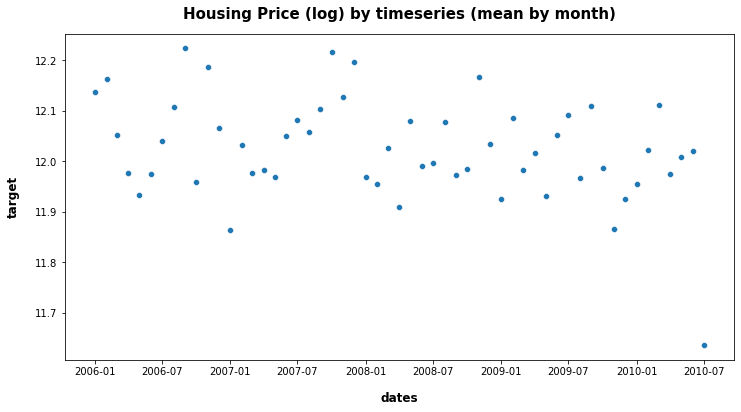

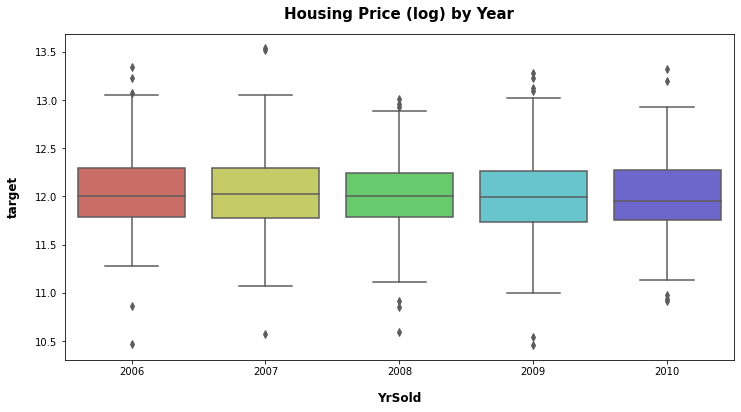

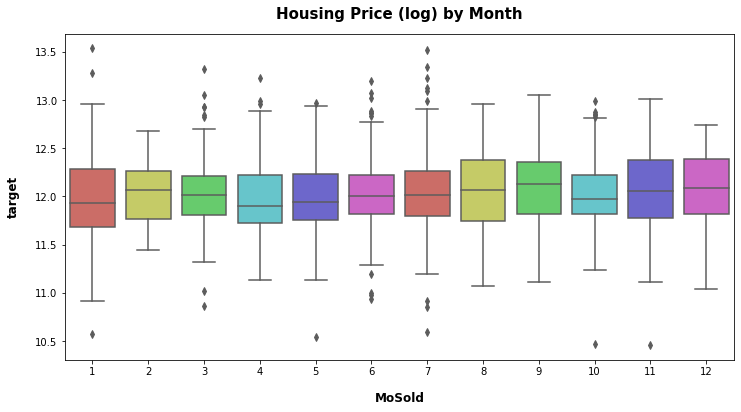

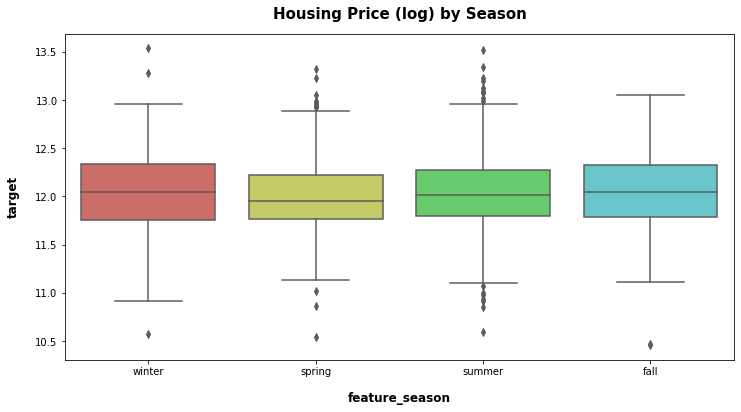

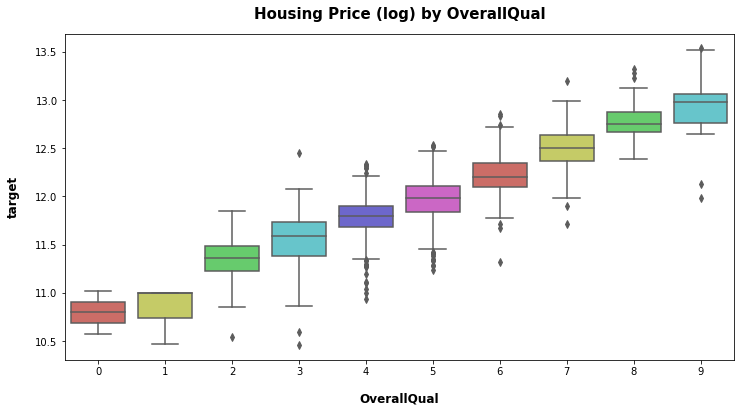

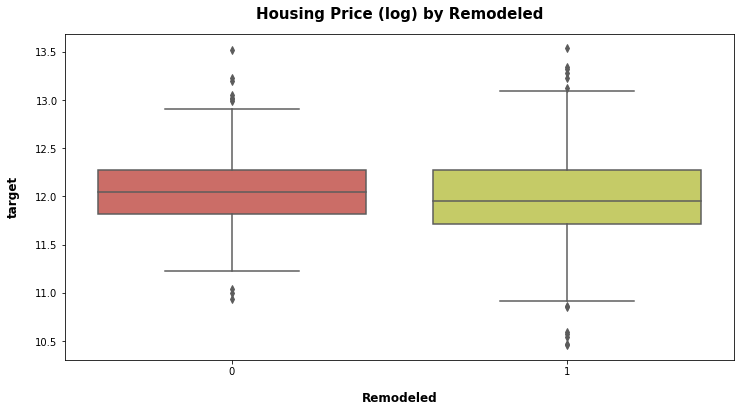

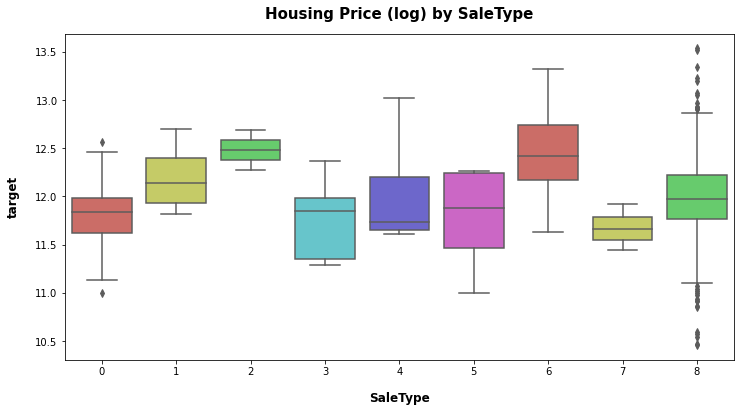

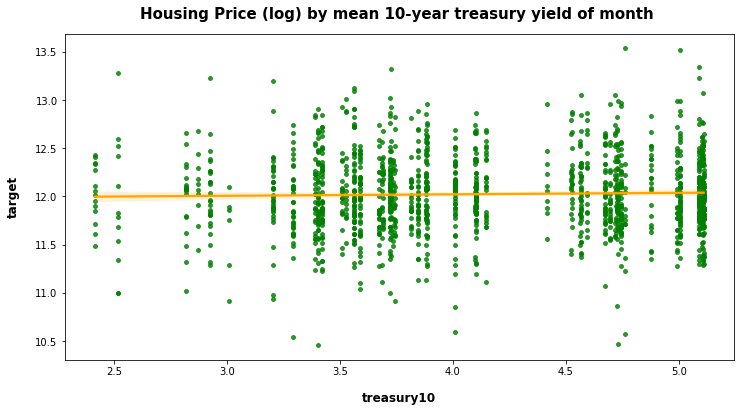

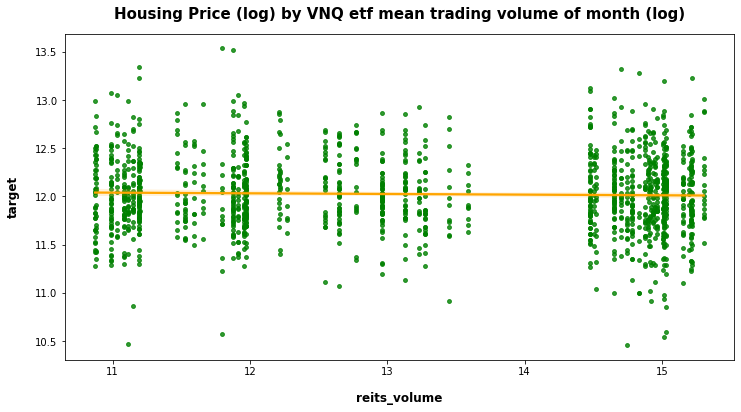

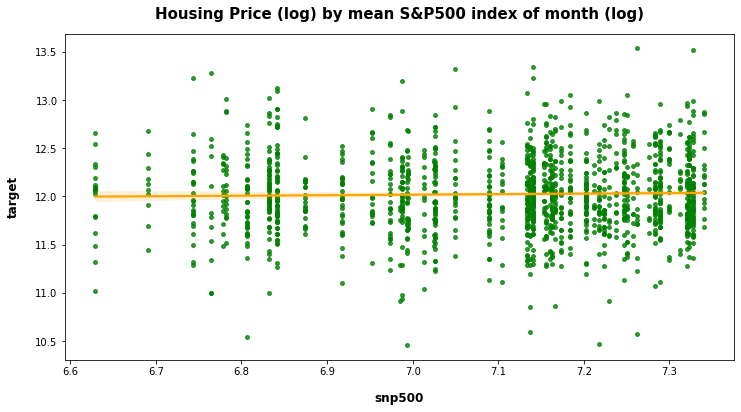

In [7]:
# ===== Visualization =====
tmp_df = full_x.copy()
tmp_df["target"] = full_y.copy()
tmp_df["dates"] = series([datetime(y, m, 1) for y, m in zip(full_x["YrSold"], full_x["MoSold"])])
tmp_df.sort_values("dates", inplace=True)
tmp_df.set_index("dates", inplace=True)

# 1. by timeseires
plt.figure(figsize=(12, 6))
graph = sns.scatterplot(x=tmp_df.groupby("dates").mean().index, y=tmp_df.groupby("dates").mean()["target"], palette=sns.hls_palette())
graph.set_title("Housing Price (log) by timeseries (mean by month)", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

plt.figure(figsize=(12, 6))
graph = sns.boxplot(x=tmp_df["YrSold"], y=tmp_df["target"], palette=sns.hls_palette())
graph.set_title("Housing Price (log) by Year", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

plt.figure(figsize=(12, 6))
graph = sns.boxplot(x=tmp_df["MoSold"], y=tmp_df["target"], palette=sns.hls_palette())
graph.set_title("Housing Price (log) by Month", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

plt.figure(figsize=(12, 6))
graph = sns.boxplot(x=tmp_df["feature_season"], y=tmp_df["target"], palette=sns.hls_palette())
graph.set_title("Housing Price (log) by Season", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

# 2. by quality related variables
plt.figure(figsize=(12, 6))
graph = sns.boxplot(x=tmp_df["OverallQual"], y=tmp_df["target"], palette=sns.hls_palette())
graph.set_title("Housing Price (log) by OverallQual", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

plt.figure(figsize=(12, 6))
graph = sns.boxplot(x=tmp_df["Remodeled"], y=tmp_df["target"], palette=sns.hls_palette())
graph.set_title("Housing Price (log) by Remodeled", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

plt.figure(figsize=(12, 6))
graph = sns.boxplot(x=tmp_df["SaleType"], y=tmp_df["target"], palette=sns.hls_palette())
graph.set_title("Housing Price (log) by SaleType", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

# 3. by finance metrics (10-year treasury yield, REITS etf VNQ trading volume, S&P500)
plt.figure(figsize=(12, 6))
graph = sns.regplot(x=tmp_df["treasury10"], y=tmp_df["target"], color="green",
                    scatter_kws={'s':15}, line_kws={"color": "orange"})
graph.set_title("Housing Price (log) by mean 10-year treasury yield of month ", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

plt.figure(figsize=(12, 6))
graph = sns.regplot(x=tmp_df["reits_volume"], y=tmp_df["target"], color="green",
                    scatter_kws={'s':15}, line_kws={"color": "orange"})
graph.set_title("Housing Price (log) by VNQ etf mean trading volume of month (log)", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

plt.figure(figsize=(12, 6))
graph = sns.regplot(x=tmp_df["snp500"], y=tmp_df["target"], color="green",
                    scatter_kws={'s':15}, line_kws={"color": "orange"})
graph.set_title("Housing Price (log) by mean S&P500 index of month (log)", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

del tmp_df

**Visualization summary**

1. OveralQual is highly correlated with the target

2. Macroscopic variables like interate rate, year show low correlation with the target

3. Rather, microscopic variables related quality and funtion show high correlation with the target

**---> Not adding S&P500, REITS ETF trading volume, 10-Year Treasury variables showed the better performance**

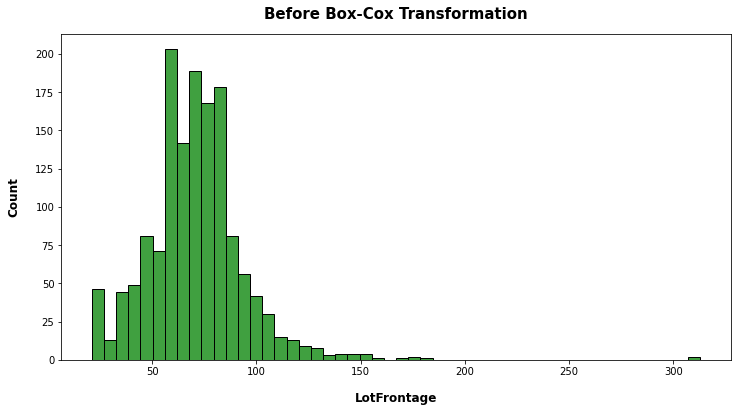

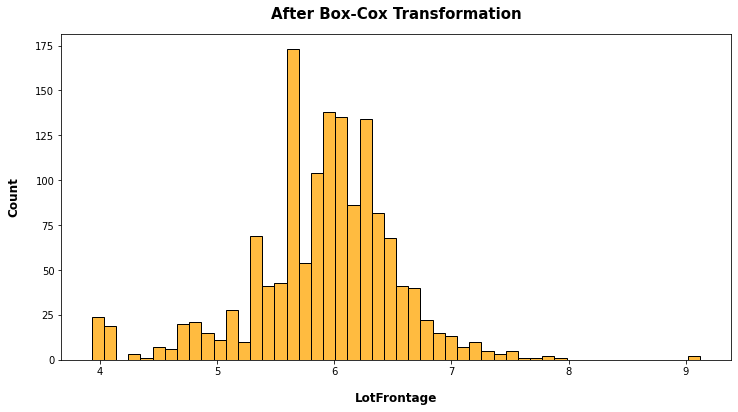

In [8]:
full_x.drop(["treasury10", "reits_volume", "snp500"], axis=1, inplace=True)
full_x = myLabelEncoder.fit_transform(full_x, date_vars + ["feature_eoy", "feature_half", "feature_quarter", "feature_season"])
test_x = myLabelEncoder.transform(test_x, date_vars + ["feature_eoy", "feature_half", "feature_quarter", "feature_season"])
bin_vars = bin_vars + ["feature_eoy", "feature_half"]
cat_vars = cat_vars + date_vars + ["feature_quarter", "feature_season"]; del date_vars
cat_vars = orderElems(cat_vars, full_x.columns)

for i in cat_vars + ord_vars + bin_vars:
    full_x[i] = full_x[i].astype("int")
    test_x[i] = test_x[i].astype("int")

# Box-Cox transformation on highly skewed data
skewnessVec = full_x[diff(full_x.columns, cat_vars + ord_vars + bin_vars)].apply(skew)
boxcoxVars = skewnessVec.index[abs(skewnessVec) > 0.75]

plt.figure(figsize=(12, 6))
graph = sns.histplot(x=full_x[boxcoxVars[0]], bins=50, color="green")
graph.set_title("Before Box-Cox Transformation", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

full_x[boxcoxVars] = full_x[boxcoxVars].apply(lambda x: boxcox1p(x, 0.15))
test_x[boxcoxVars] = test_x[boxcoxVars].apply(lambda x: boxcox1p(x, 0.15))

plt.figure(figsize=(12, 6))
graph = sns.histplot(x=full_x[boxcoxVars[0]], bins=50, color="orange")
graph.set_title("After Box-Cox Transformation", fontsize=15, fontweight="bold", pad=15)
graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
plt.show()

# Anomaly Detection (Skipping, no helpful for performance)

**Isolation Forest**

* I selected bagging for subsampling method, 1000 trees and 2 features for hyper-parameter

* And removed the 1% data which is detected as anomalies from the bottom

In [9]:
# # ===== Anomaly Detection =====
# ad_eif = IsolationForest(n_estimators=1000, max_samples=full_x.shape[0], max_features=2, contamination=0.01,
#                          bootstrap=True, n_jobs=multiprocessing.cpu_count(), random_state=898)
# anomalyVec = ad_eif.fit_predict(full_x)
# print("Detected anomalies --->", (anomalyVec == -1).sum())

# # 1. Before removing
# plt.figure(figsize=(12, 6))
# graph = sns.histplot(x=full_y, bins=50, color=myColors[1])
# graph.set_title("Housing Price (log) before removing anomalies", fontsize=15, fontweight="bold", pad=15)
# graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
# graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
# # plt.show()

# # 1. After removing
# plt.figure(figsize=(12, 6))
# graph = sns.histplot(x=full_y[anomalyVec == 1], bins=50, color=myColors[2])
# graph.set_title("Housing Price (log) before removing anomalies", fontsize=15, fontweight="bold", pad=15)
# graph.set_xlabel(graph.get_xlabel(), fontsize=12, fontweight="bold", labelpad=15)
# graph.set_ylabel(graph.get_ylabel(), fontsize=12, fontweight="bold", labelpad=15)
# # plt.show()

In [10]:
# full_x = full_x[anomalyVec == 1]
# full_x.reset_index(drop=True, inplace=True)
# full_y = full_y[anomalyVec == 1]
# full_y.reset_index(drop=True, inplace=True)

# Feature Importance Visualization

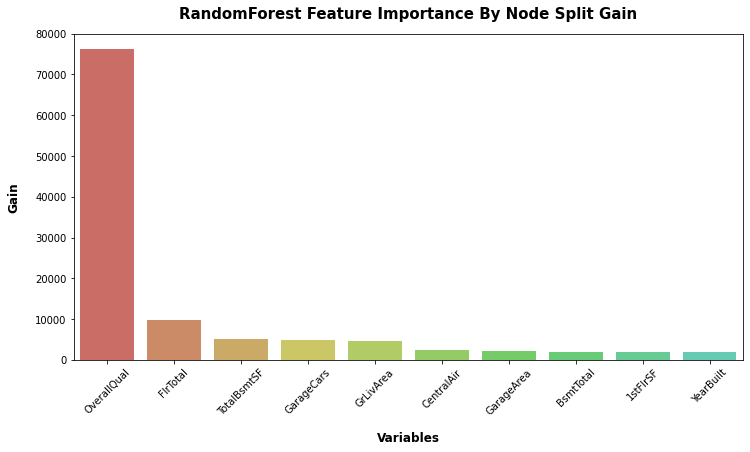

In [11]:
# RandomForest Feature Importance
feature_selector = lgb.LGBMRegressor(boosting_type="rf", objective="regression",
                                     n_estimators=1000, learning_rate=1e-3, num_leaves=2**6-1,
                                     subsample=0.6, subsample_freq=1, importance_type="gain",
                                     silent=True, n_jobs=multiprocessing.cpu_count(), random_state=6565)
model_fs = SelectFromModel(feature_selector, threshold="mean")
model_fs.fit(full_x, full_y, categorical_feature=findIdx(full_x.columns, cat_vars))

# descending order the columns by feature importance (all features)
fs_order = np.argsort(-model_fs.estimator_.feature_importances_)
fs_cols = full_x.columns[fs_order]
fs_scores = model_fs.estimator_.feature_importances_[fs_order]

plt.figure(figsize=(12, 6))
graph = sns.barplot(x=fs_cols[:10], y=fs_scores[:10], palette=sns.hls_palette(20))
graph.set_title("RandomForest Feature Importance By Node Split Gain", fontsize=15, fontweight="bold", pad=15)
graph.set_xticklabels(graph.get_xticklabels(), rotation=45)
graph.set_xlabel("Variables", fontsize=12, fontweight="bold", labelpad=15)
graph.set_ylabel("Gain", fontsize=12, fontweight="bold", labelpad=15)
plt.show()

**Feature Importance Summary**

* 'OverallQual' shows high importance for this dataset

**Train, Valdation Split**

* I used the validation set split by 'OverallQual' which shows high importance

In [12]:
myOneHotEncoder = MyOneHotEncoder(label_preset=myLabelEncoder.dic_cat)
full_x_oh = myOneHotEncoder.fit_transform(full_x, cat_vars)
test_x_oh = myOneHotEncoder.transform(test_x, cat_vars)

stratVec = full_x["OverallQual"].copy()
# train, validation split
train_x, val_x, train_x_oh, val_x_oh, train_y, val_y = tts(full_x, full_x_oh, full_y, stratify=stratVec,
                                                           test_size=0.2, shuffle=True, random_state=54321)

del full_x, full_x_oh, full_y

result_val = easyIO(None, "../input/housingprice-dataset-prep/result_val.pickle", op="r")

print("shape check")
print("train_x :", train_x.shape)
print("val_x :",val_x.shape)
print("test_x :",test_x.shape)

print("train_x_oh :",train_x_oh.shape)
print("val_x_oh :",val_x_oh.shape)
print("train_x_oh :",train_x_oh.shape)

print("train_y :",train_y.shape)
print("val_y :",val_y.shape)

shape check
train_x : (1168, 86)
val_x : (292, 86)
test_x : (1459, 86)
train_x_oh : (1168, 259)
val_x_oh : (292, 259)
train_x_oh : (1168, 259)
train_y : (1168,)
val_y : (292,)


# Modeling

* Below are the models I am trying.

> ElasticNet, SVM, XGBoost(gbtree), LightGBM(RandomForest), LightGBM(GOSS), CatBoost(GBM), KNN

> Stacking Ensemble, 5 kinds of MLP, MLP With Boosting

**Validation Performance (tried models)**

In [13]:
perf_tabel = dataframe()
for k, v in result_val.items():
    if v is not None:
        if "performance" in v.keys():
            perf_tabel = pd.concat([perf_tabel, dataframe([[k] + list(v["performance"].values())])], axis=0, ignore_index=True)
perf_tabel.columns = ["Models", "RMSE", "R2"]
perf_tabel.sort_values("RMSE", inplace=True)
print(perf_tabel)

              Models      RMSE        R2
5            CAT_GBM  0.108519  0.921624
0         ElasticNet  0.108642  0.921447
2            XGB_GBT  0.111840  0.916753
1                SVM  0.118470  0.906590
4           LGB_GOSS  0.118676  0.906266
11  MLP_MultiActs_V1  0.120126  0.903962
10         MLP_LP_V1  0.124157  0.897408
9    MLP_DenseNet_V1  0.125777  0.894713
7        MLP_Desc_V1  0.127141  0.892418
8      MLP_ResNet_V1  0.127682  0.891500
3             LGB_RF  0.136172  0.876590
6                KNN  0.218636  0.681861


**Stacking Ensemble**

**ElasticNet**

In [14]:
print(result_val["ElasticNet"]["best_params"])

{'alpha': 0.001, 'l1_ratio': 0.99}


**XGBoost - gbtree**

In [15]:
print(result_val["XGB_GBT"]["best_params"])

{'colsample_bytree': 0.8, 'gamma': 0.0, 'max_depth': 6, 'min_child_weight': 1, 'reg_lambda': 0.1, 'subsample': 0.8}


**CatBoost - traditional gradient boosting**

In [16]:
print(result_val["CAT_GBM"]["best_params"])

{'bagging_temperature': 0.2, 'l2_leaf_reg': 0.1, 'max_depth': 6, 'rsm': 0.8}


In [17]:
# ===== Stacking Ensemble =====
seed_base_models = 933
kf = StratifiedKFold(10, shuffle=True, random_state=7878)


# base learner definition
stacking_base_models = [
    ('ElasticNet', make_pipeline(StandardScaler(), lm.ElasticNet(alpha=result_val["ElasticNet"]["best_params"]["alpha"],
                                                                 l1_ratio=result_val["ElasticNet"]["best_params"]["l1_ratio"],
                                                                 normalize=False, random_state=seed_base_models+1))),
    ('XGB_GBT', xgb.XGBRegressor(booster="gbtree", objective="reg:squarederror", learning_rate=5e-3,
                                 n_estimators=result_val["XGB_GBT"]["model"].best_iteration,
                                 max_depth=result_val["XGB_GBT"]["best_params"]["max_depth"],
                                 subsample=result_val["XGB_GBT"]["best_params"]["subsample"],
                                 reg_lambda=result_val["XGB_GBT"]["best_params"]["reg_lambda"],
                                 min_child_weight=result_val["XGB_GBT"]["best_params"]["min_child_weight"],
                                 gamma=result_val["XGB_GBT"]["best_params"]["gamma"],
                                 colsample_bytree=0.8, verbosity=0, use_label_encoder=False,
                                 n_jobs=None, random_state=seed_base_models+2)),
    ('CAT_GBM', cat.CatBoostRegressor(boosting_type="Plain", loss_function="RMSE", learning_rate=5e-2,
                                      n_estimators=result_val["CAT_GBM"]["model"].best_iteration_,
                                      max_depth=result_val["CAT_GBM"]["best_params"]["max_depth"],
                                      bagging_temperature=result_val["CAT_GBM"]["best_params"]["bagging_temperature"],
                                      l2_leaf_reg=result_val["CAT_GBM"]["best_params"]["l2_leaf_reg"],
                                      rsm=0.8, logging_level="Silent",
                                      thread_count=None, random_state=seed_base_models+4))
]

# meta learner definition
meta_learner_model = lm.ElasticNetCV(cv=10, alphas=np.linspace(1e-2, 1e+2, 100).tolist(), random_state=seed_base_models+100,
                                     l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 0.99])

model_se = ensemble.StackingRegressor(estimators=stacking_base_models,
                                      final_estimator=meta_learner_model,
                                      cv=kf.split(train_x_oh, train_x["OverallQual"]),  
                                      n_jobs=multiprocessing.cpu_count())
model_se.fit(train_x_oh, train_y)

print("Validation RMSE --->", np.sqrt(metrics.mean_squared_error(val_y, model_se.predict(val_x_oh))))
print("Validation R2 --->", metrics.r2_score(val_y, model_se.predict(val_x_oh)))

pred_test = model_se.predict(test_x_oh)

Validation RMSE ---> 0.10420477333520974
Validation R2 ---> 0.9277318670745299


# Submission

* Submitting after rounding all values to integer

In [18]:
submission = read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission[target_var] = np.expm1(pred_test).round().astype(int)
submission.to_csv("./submission.csv", index=False)